# Piotroski F-Skorudur.

F-Skor Filtrelemesi de denilen F-Skoru, Joseph D. Piotroski tarafından geliştirilmiştir. Yöntemin amacı, bir şirketin finansal sağlığını 0-9 arası bir skor ile ölçmektir. Skorlama için bilanço, gelir ve nakit akış tablosu kullanılır.

Yöntemde 3 başlık ve 9 kriter bulunmaktadır.

1. Karlılık
1.1. Net Kar: Cari dönemde pozitifse 1, değilse 0 eklenir.
1.2. Aktif Karlılığı: Bir önceki döneme göre cari dönemde artış varsa 1, yoksa 0 eklenir.
1.3. Nakit Akışı: Cari dönemde pozitifse 1, değilse 0 eklenir.
1.4. Karın Kalitesi: Nakit akışı net kardan büyükse 1, değilse 0 eklenir.

2. Borçluluk, likidite ve fon kaynakları
2.1. Kaldıraç: Uzun vadeli borçluluk oranında bir önceki döneme göre düşüş varsa 1, yoksa 0 eklenir.
2.2. Likidite (Cari Oran): Bir önceki döneme göre artış varsa 1, yoksa 0 eklenir.
2.3. Seyreltme: Yeni hisse senedi çıkarılmamışsa 1, çıkarılmışsa 0 eklenir.

3. Operasyonel Etkinlik
3.1. Brüt Kar Marjı: Bir önceki döneme göre artış varsa 1, yoksa 0 eklenir.
3.2. Aktif Devir Hızı: Bir önceki döneme göre artış varsa 1, yoksa 0 eklenir.

Buna göre şirket en düşük 0, en yüksek 9 skorunu alabilir. Değerlendirmeler bazı yerlerde değişiklik gösterse de bu çalışmada 7-8-9 için güçlü, 4-5-6 için nötr, 0-1-2-3 için güçsüz sınıflandırmasını seçelim.

Uygulamada, şirketlerin finansal tablolarına yfinance kütüphanesi ile ulaşacağız ve BIST30 endeksindeki 30 şirketi (bazıları hata verdiği için çıkarıldı) F-Skoruna göre sıralayacağız.

In [16]:


import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [17]:
def yfinance_data(symbol):
    stock = yf.Ticker(symbol)
    return {
        'financials': stock.financials,
        'balance_sheet': stock.balance_sheet,
        'cash_flow': stock.cash_flow
    }

In [18]:
# Profitability

def net_income(financials_df):
    return financials_df.loc['Net Income'].iloc[0]

def return_on_assets(balance_sheet_df, financials_df):
    total_assets = balance_sheet_df.loc['Total Assets']
    avg_assets = (total_assets.iloc[0] + total_assets.iloc[1]) / 2
    return net_income(financials_df) / avg_assets

def operating_cash_flow(cash_flow_df):
    return cash_flow_df.loc['Operating Cash Flow'].iloc[0]

# Leverage, Liquidity, and Source of Funds

def long_term_debt(balance_sheet_df):
    current = balance_sheet_df.loc['Long Term Debt'].iloc[0]
    previous = balance_sheet_df.loc['Long Term Debt'].iloc[1]
    return previous - current

def current_ratio(balance_sheet_df):
    current_assets = balance_sheet_df.loc['Current Assets']
    current_liabilities = balance_sheet_df.loc['Current Liabilities']
    ratio1 = current_assets.iloc[0] / current_liabilities.iloc[0]
    ratio2 = current_assets.iloc[1] / current_liabilities.iloc[1]
    return ratio1 - ratio2

def new_shares(balance_sheet_df):
    current = balance_sheet_df.loc['Common Stock'].iloc[0]
    previous = balance_sheet_df.loc['Common Stock'].iloc[1]
    return current - previous

# Operating Efficiency

def gross_margin(financials_df):
    current = financials_df.loc['Gross Profit'].iloc[0]/financials_df.loc['Total Revenue'].iloc[0]
    previous = financials_df.loc['Gross Profit'].iloc[1]/financials_df.loc['Total Revenue'].iloc[1]
    return current - previous

def asset_turnover_ratio(financials_df, balance_sheet_df):
    total_assets = balance_sheet_df.loc['Total Assets']
    avg_assets1 = (total_assets.iloc[0] + total_assets.iloc[1]) / 2
    avg_assets2 = (total_assets.iloc[1] + total_assets.iloc[2]) / 2
    atr1 = financials_df.loc['Total Revenue'].iloc[0] / avg_assets1
    atr2 = financials_df.loc['Total Revenue'].iloc[1] / avg_assets2
    return atr1 - atr2

# Piotroski F-Score

def piotroski_f_score(financials_df, balance_sheet_df, cash_flow_df):
    # Initialize the score to 0
    score = 0

    # Create a dictionary to store the results for each criterion
    results = {
        'Net Income': False,
        'ROA': False,
        'CFO': False,
        'CFO > Net Income': False,
        'Long Term Debt Decreased': False,
        'Current Ratio Increased': False,
        'No New Shares Issued': False,
        'Gross Margin Increased': False,
        'Asset Turnover Ratio Increased': False
    }

    # Positive net income (Score +1)
    if net_income(financials_df) > 0:
        results['Net Income'] = True
        score +=1

    # Positive return on assets (ROA) in the current year (Score +1)
    if return_on_assets(balance_sheet_df, financials_df) > 0:
        results['ROA'] = True
        score +=1

    # Positive operating cash flow in the current year (Score +1)
    if operating_cash_flow(cash_flow_df) > 0:
        results['CFO'] = True
        score +=1

    # Cash flow from operations being greater than net Income (quality of earnings)
    if operating_cash_flow(cash_flow_df) > net_income(financials_df):
        results['CFO > Net Income'] = True
        score +=1

    # Lower amount of long term debt in the current period, compared to the previous year (decreased leverage) (Score +1)
    if long_term_debt(balance_sheet_df) > 0:
        results['Long Term Debt Decreased'] = True
        score +=1

    # Higher current ratio this year compared to the previous year (more liquidity) (Score +1)
    if current_ratio(balance_sheet_df) > 0:
        results['Current Ratio Increased'] = True
        score +=1

    # No new shares were issued in the last year (lack of dilution) (Score +1)
    if new_shares(balance_sheet_df) < 1:
        results['No New Shares Issued'] = True
        score +=1

    # A higher gross margin compared to the previous year (Score +1)
    if gross_margin(financials_df) > 0:
        results['Gross Margin Increased'] = True
        score +=1

    # A higher asset turnover ratio compared to the previous year (Score +1)
    if asset_turnover_ratio(financials_df, balance_sheet_df) > 0:
        results['Asset Turnover Ratio Increased'] = True
        score +=1

    return score, results

Error processing AKBNK.IS: 'Long Term Debt'
Error processing BIMAS.IS: 'Long Term Debt'
Error processing SAHOL.IS: 'Long Term Debt'
Error processing KOZAL.IS: 'Long Term Debt'
Error processing GARAN.IS: 'Long Term Debt'
Error processing ISCTR.IS: 'Long Term Debt'
Error processing YKBNK.IS: 'Long Term Debt'

The Piotroski F Score for ALARK.IS is 7
Results for Each Criterion:
Net Income: +1
ROA: +1
CFO: +1
CFO > Net Income: 0
Long Term Debt Decreased: 0
Current Ratio Increased: +1
No New Shares Issued: +1
Gross Margin Increased: +1
Asset Turnover Ratio Increased: +1

The Piotroski F Score for ARCLK.IS is 7
Results for Each Criterion:
Net Income: +1
ROA: +1
CFO: +1
CFO > Net Income: +1
Long Term Debt Decreased: +1
Current Ratio Increased: 0
No New Shares Issued: +1
Gross Margin Increased: 0
Asset Turnover Ratio Increased: +1

The Piotroski F Score for ASELS.IS is 6
Results for Each Criterion:
Net Income: +1
ROA: +1
CFO: +1
CFO > Net Income: 0
Long Term Debt Decreased: 0
Current Ratio Incr

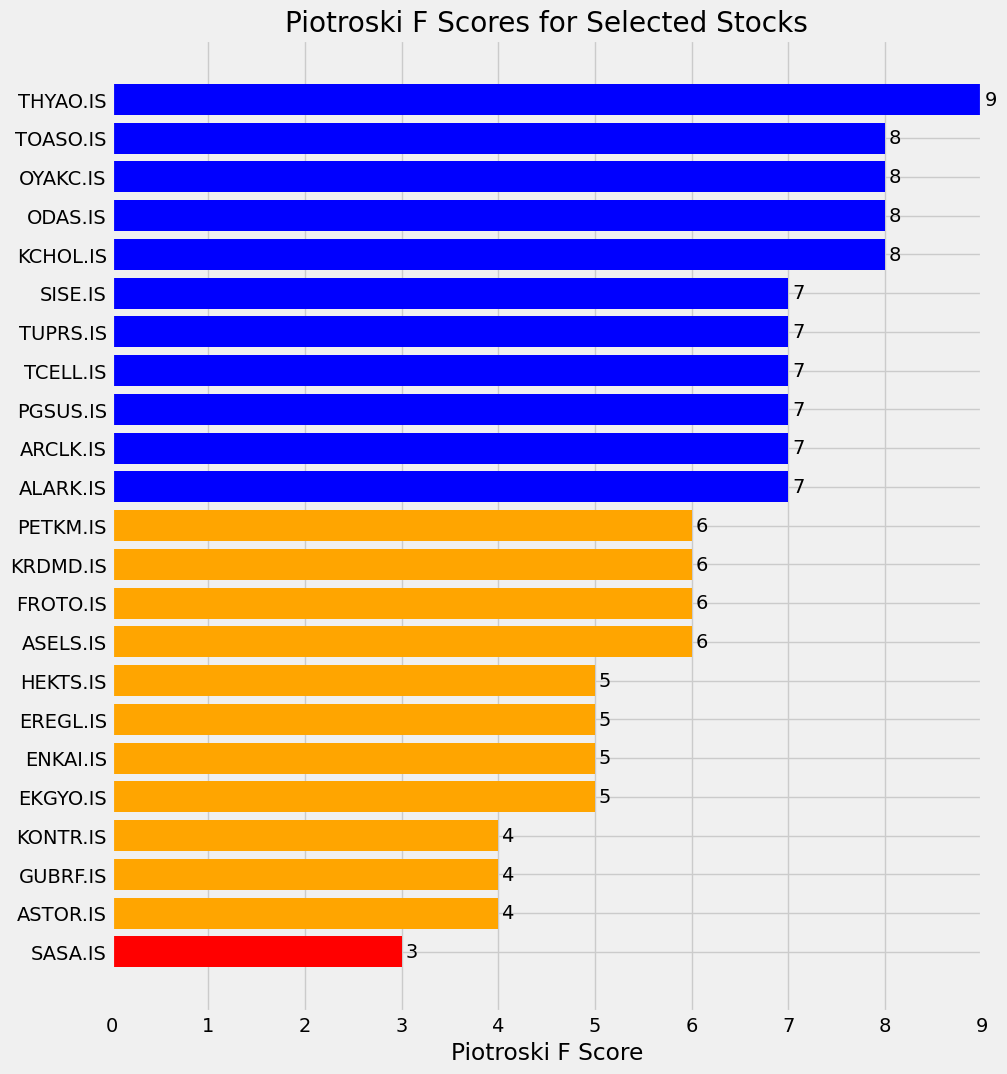

In [19]:
def piotroski_f_score_multiple(symbols):
    all_scores = {}

    for symbol in symbols:
        try:
            all_financial_data = yfinance_data(symbol)
            financials = all_financial_data['financials']
            balance_sheet = all_financial_data['balance_sheet']
            cash_flow = all_financial_data['cash_flow']

            final_score, criteria_results = piotroski_f_score(financials, balance_sheet, cash_flow)
            all_scores[symbol] = {'final_score': final_score, 'criteria_results': criteria_results}
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")

    return all_scores

symbols_list = pd.read_excel("/Users/omerfaruksezer/Downloads/bist30_stocks.xlsx")['Symbol'].astype(str).apply(lambda x: x + '.IS').tolist()
all_scores = piotroski_f_score_multiple(symbols_list)

def display_piotroski_scores(all_scores):
    for symbol, scores in all_scores.items():
        print(f"\nThe Piotroski F Score for {symbol} is {scores['final_score']}")
        print("Results for Each Criterion:")
        for criterion, result in scores['criteria_results'].items():
            print(f"{criterion}: {'+1' if result else '0'}")

display_piotroski_scores(all_scores)

def plot_piotroski_scores(all_scores):
    symbols = list(all_scores.keys())
    scores = [scores['final_score'] for scores in all_scores.values()]

    sorted_symbols, sorted_scores = zip(*sorted(zip(symbols, scores), key=lambda x: x[1], reverse=False))
    colors = ['blue' if s in [7, 8, 9] else 'orange' if s in [4, 5, 6] else 'red' for s in sorted_scores]

    plt.figure(figsize=(10, 12))
    bars = plt.barh(sorted_symbols, sorted_scores, color=colors, height=0.8)

    for bar, score, symbol in zip(bars, sorted_scores, sorted_symbols):
        plt.text(score + 0.1, symbol, str(score), ha='center', va='center')

    plt.ylabel('')
    plt.xlabel('Piotroski F Score')
    plt.title('Piotroski F Scores for Selected Stocks')
    plt.xlim(0, 9)
    plt.show()

plot_piotroski_scores(all_scores)